# Enhanced Colliding Bodies Optimization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Pseudocode
```
allot random positions
iterate:
    get mass
    sort in descending order based on mass
    if iter == 0:
        setup memory vector
    else:
        replace bottom X entries with memory entries
    save top x entries in memory
    sort cb again
    plot # optional
    set initial velocities
    calculate new velocities
    calculate new positions
    escape minima by incorporating Pro
    update epsilon
```

## Dimensions
- xmin = (num_varibales), meaning this is a 1D array
- xmax = (num_varibales)
- cb = (num_agents, num_vars+1)
- memory = (X, num_vars+1)
- velocities = (num_agents, num_variables)
- new_velocities = (num_agents, num_variables)

In [2]:
def fit_func(arr):
    z = (arr[0] - 20)**2 + (arr[1] - 20)**2
    return z

In [3]:
def plot_points(arr):
    sns.set(style = "darkgrid")
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection = '3d')

    x = arr[:,1]
    y = arr[:,2]
    z = fit_func([x, y])

    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")

    ax.scatter(x, y, z, s=50, color='k')
    ax.scatter(x[0], y[0], z[0], s=100, color='red')

    plt.xticks(range(15,25))
    plt.yticks(range(15,25))
    ax.set_zlim3d(0,50)
    plt.xlim(15,25)
    plt.ylim(15,25)
    ax.view_init(20, 50)

    plt.show()

In [4]:
def cob(xmin, xmax, num_agents=50, num_vars=2, epsilon=1, max_iterations=40, Pro=0.25, X=5):
    '''
    num_agents defines the number of colliding bodies.
    num_vars defines the number of variables to be constrained. Make sure this matches the variavbles in the fit-function.
    xmin & xmax are a vectors containing min and max values of each variable to be minimized.
    epsilon defines the initial coefficient of restitution. max_value=1
    X defines the number of entries to be saved in memory. Research suggests that the best value for it is num_agents/10
    Pro is used for escaping local minima. Research suggests that the best value for it is 0.25.
    '''
    # coordinates = xmin + np.random.uniform(size=(num_agents, num_vars)) * (xmax - xmin)
    velocities = np.zeros(shape=(num_agents, num_vars))
    cb = np.zeros(shape=(num_agents, num_vars+1))   # +1 to accomodate mass
    cb[:, 1:] = xmin + np.random.uniform(size=(num_agents, num_vars)) * (xmax - xmin)
    mid = int(num_agents / 2)    # required as num_agents/2 can't be passed while slicing matrices

    for iteration in range(max_iterations+1):
        # update mass
        denominator = 0
        for agent in range(num_agents):
            denominator += 1 / fit_func(cb[agent, 1:])
        for agent in range(num_agents):
            cb[agent, 0] = (1 / fit_func(cb[agent, 1:])) / denominator
        
        # sort cb
        cb = cb[np.argsort(cb[:,0])[::-1]]    # sort cb in descending order based on mass

        # memory vector
        if(iteration == 0):
            memory = np.zeros(shape = (X, cb.shape[1]))

        #replace bottom X entries of cb with memory
        else:
            cb[-X:, :] = memory
        
        # save top X entries in memory
        memory = cb[:X, :]
        # sort again
        cb = cb[np.argsort(cb[:,0])[::-1]]

        #plot
        if(iteration % 20 == 0):
            plot_points(cb)
            print("\n//Iteration", iteration)
            print("Top 3 values")
            df = pd.DataFrame(cb[:3,:], columns=["Mass", "x1", "x2"])
            print(df)
            print("\nStandard deviation of Mass:", np.round(df.Mass.std(), 2))
            print("Standard deviation of x1:", np.round(df.x1.std(), 2))
            print("Standard deviation of x2:", np.round(df.x2.std(), 2))
            print("\n\n\n")

        # set initial velocities
        velocities[:mid, :] = 0
        velocities[mid:, :] = cb[:mid, 1:] - cb[mid:, 1:]

        #set new velocities post collision
        # stationary
        velocities[:mid, :] = velocities[mid:, :] * (1+epsilon) * (cb[mid:, 0] / (cb[:mid, 0] + cb[mid:, 0])).reshape(-1,1)

        # moving
        velocities[mid:, :] = velocities[mid:, :] * ((cb[mid:, 0] - (epsilon*cb[:mid, 0])) / (cb[:mid, 0] + cb[mid:, 0])).reshape(-1,1)

        # Calculate new positions. Make sure to calculate the position of moving bodies prior to those of stationary ones
        # moving
        cb[mid:, 1:] = cb[:mid, 1:] + (np.random.uniform(size=(mid, velocities.shape[1])) * velocities[mid:, :])

        # stationary
        cb[:mid, 1:] = cb[:mid, 1:] + (np.random.uniform(size=(mid, velocities.shape[1])) * velocities[:mid, :])

        #Escape local minima
        for row in range(num_agents):
            Random = np.random.uniform()
            if (Random < Pro):
                # randomly select 1 dimension to change
                dim = np.random.randint(0, num_vars)
                cb[row, dim+1] = xmin[dim] + np.random.uniform() * (xmax[dim] - xmin[dim])
        
        # update epsilon
        epsilon = 1 - iteration/max_iterations
    return cb
# plt.show()

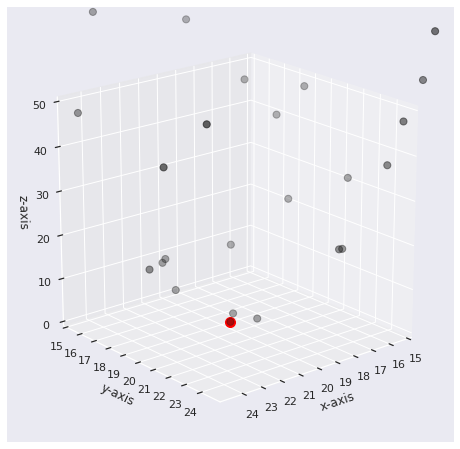


//Iteration 0
Top 3 values
       Mass         x1         x2
0  0.544358  19.899038  19.484114
1  0.150068  19.018627  20.198175
2  0.138232  19.445067  19.116683

Standard deviation of Mass: 0.23
Standard deviation of x1: 0.44
Standard deviation of x2: 0.55






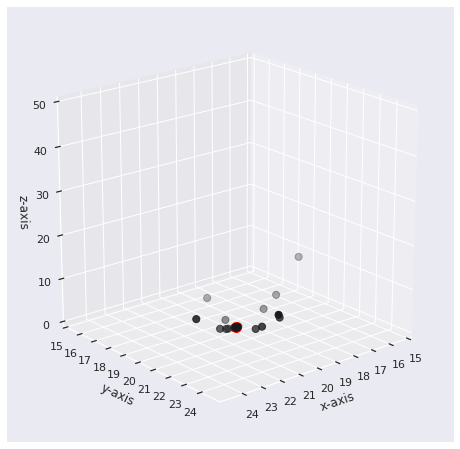


//Iteration 20
Top 3 values
       Mass         x1         x2
0  0.224665  20.001577  20.001835
1  0.207401  20.003619  19.998806
2  0.141229  20.002898  19.999044

Standard deviation of Mass: 0.04
Standard deviation of x1: 0.0
Standard deviation of x2: 0.0






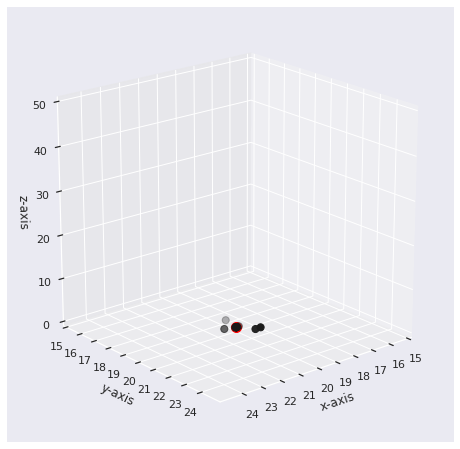


//Iteration 40
Top 3 values
       Mass         x1         x2
0  0.068925  20.000002  19.999938
1  0.068685  20.000009  19.999938
2  0.066514  20.000061  19.999984

Standard deviation of Mass: 0.0
Standard deviation of x1: 0.0
Standard deviation of x2: 0.0






In [5]:
cb = cob(xmin=np.array([10,10]), xmax=np.array([30,30]))

In [6]:
print("Best answer:", np.round(cb[0], 2))

Best answer: [ 0.07 20.   20.  ]


Correct answer: `[don't care, 20, 20]`